# |This notebook contains initial quick experiments with the SIR model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.sir import SIROneStain

# One stain

In [6]:
# t - time cycle (5 days)
# N - total population
# S(t) - susceptible
# I(t) - infected
# R(t) - recovered
# D - number of days an infected person has and spreads the disease 
# beta - infection rate, expected number of people an infected person infects per time cycle
# gamma = 1/D - recovery rate, fraction of infected people that recover per time cycle
# R0 = beta / gamma - basic reproduction number
# beta = gamma * R0

In [7]:
start_day = '2021-01-09'
end_day = '2022-01-01'
days_in_cycle = 5
dates = pd.date_range(start=start_day,
                      end=end_day,
                      freq=f"{days_in_cycle}D")

t = np.array(range(len(dates)))
dates, t

(DatetimeIndex(['2021-01-09', '2021-01-14', '2021-01-19', '2021-01-24',
                '2021-01-29', '2021-02-03', '2021-02-08', '2021-02-13',
                '2021-02-18', '2021-02-23', '2021-02-28', '2021-03-05',
                '2021-03-10', '2021-03-15', '2021-03-20', '2021-03-25',
                '2021-03-30', '2021-04-04', '2021-04-09', '2021-04-14',
                '2021-04-19', '2021-04-24', '2021-04-29', '2021-05-04',
                '2021-05-09', '2021-05-14', '2021-05-19', '2021-05-24',
                '2021-05-29', '2021-06-03', '2021-06-08', '2021-06-13',
                '2021-06-18', '2021-06-23', '2021-06-28', '2021-07-03',
                '2021-07-08', '2021-07-13', '2021-07-18', '2021-07-23',
                '2021-07-28', '2021-08-02', '2021-08-07', '2021-08-12',
                '2021-08-17', '2021-08-22', '2021-08-27', '2021-09-01',
                '2021-09-06', '2021-09-11', '2021-09-16', '2021-09-21',
                '2021-09-26', '2021-10-01', '2021-10-06', '2021-

In [25]:
population = N = 144500000
beta = 1.23
D = 1
gamma = 1.0 / D
alpha = 0.066
rho = 1/14

# Initial conditions
I0 = 563754
Rec0 = 27311290
S0 = population - I0 - Rec0
D0 = 0
initial_conditions = (S0, I0, Rec0, D0)
S0

116624956

In [26]:
# # Integrate the SIR equations over the time grid, t.
# ret = odeint(model_step, initial_conditions, t, args=(population, beta, gamma))
# S, I, R = ret.T

In [27]:
model = SIROneStain(population, beta, gamma, alpha=alpha, rho=rho)

In [29]:
S, I, R, D = model._predict(t, initial_conditions)

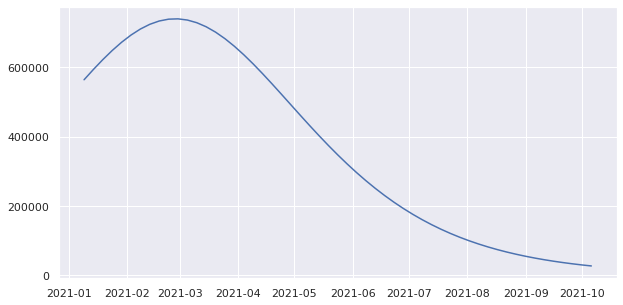

In [30]:
plt.figure(figsize=(10,5))
plt.plot(dates[:55], I[:55])
plt.yticks([0, 200_000, 400_000, 600_000])
#plt.xticks(dates[[10, 23, 35, 47]])
plt.show()

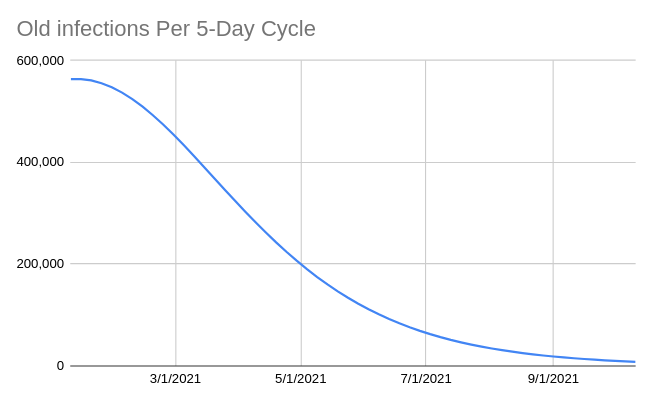

# Two stains

In [31]:
def model_step(initial_conditions, t, population, beta_s1, beta_s2, gamma):
    S, Is1, Is2, R = initial_conditions
    I = Is1 + Is2
    #dSdt = -beta_s1 * S * Is1 / population - beta_s2 * S * Is2 / population
    dSdt = -S/population * (beta_s1 * Is1 + beta_s2 * Is2 )
    
    dIs1dt = beta_s1 * S * Is1 / population - gamma * Is1
    dIs2dt = beta_s2 * S * Is2 / population - gamma * Is2
    
    dRdt = gamma * I
    return dSdt, dIs1dt, dIs2dt, dRdt

## Parameters roughly like in Zvi's article

In [56]:
population = N = 144500000
beta_stain_1 = 1.23
beta_stain_2 = beta_stain_1 * 1.5
D = 1
gamma = 1.0 / D
print('R0 old stain:', beta_stain_1/gamma)
print('R0 new stain:', beta_stain_2/gamma)

print('beta old stain:', beta_stain_1)
print('beta new stain:', beta_stain_2)
# Initial conditions
initial_new_stain_rate = 0.000065
I0 = 563754

I0s1 = (1-initial_new_stain_rate)*I0
I0s2 = (initial_new_stain_rate)*I0
Rec0 = 27311290
S0 = population - I0 - Rec0
initial_conditions = (S0, I0s1, I0s2, Rec0)

ret = odeint(model_step, initial_conditions, t, args=(population, beta_stain_1, beta_stain_2, gamma))
S, Is1, Is2, R = ret.T

R0 old stain: 1.23
R0 new stain: 1.845
beta old stain: 1.23
beta new stain: 1.845


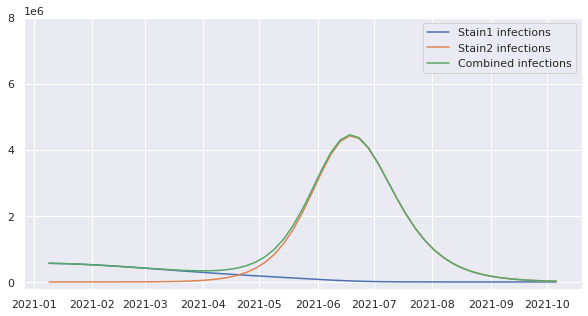

In [55]:
plt.figure(figsize=(10,5))
plt.plot(dates[:55], Is1[:55], label='Stain1 infections')
plt.plot(dates[:55], Is2[:55], label='Stain2 infections')
plt.plot(dates[:55], Is1[:55] + Is2[:55], label='Combined infections')
plt.yticks([0, 2e6, 4e6, 6e6, 8e6])
plt.legend()
plt.show()

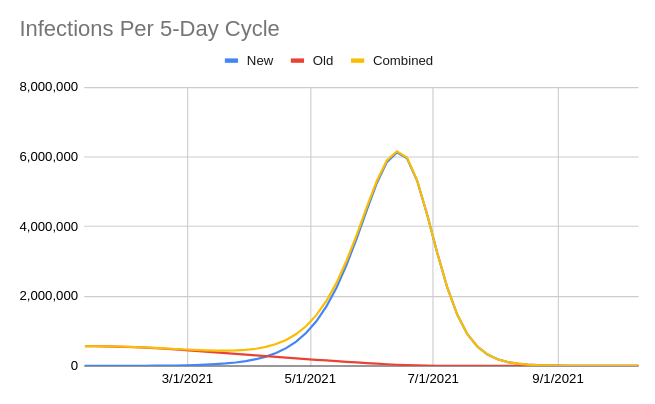

## Realistic parameters

In [62]:
population = N = 144500000
# D = 3
D = 9.5
gamma = 1.0 / D
r0_base = 3.5
q = 0.7

r0 = r0_base - r0_base*q

print('Rt under quarantine', r0)

r0_stain1 = r0
beta_stain_1 = r0_stain1 * gamma

beta_stain_2 = beta_stain_1 * 1.5
r0_stain2 = beta_stain_2 * gamma

print('R0 old stain:', r0_stain1)
print('R0 new stain:', r0_stain2)

print('beta old stain:', beta_stain_1)
print('beta new stain:', beta_stain_2)

# Initial conditions
initial_new_stain_rate = 0.006
I0 = 563754

I0s1 = (1-initial_new_stain_rate)*I0
I0s2 = (initial_new_stain_rate)*I0
Rec0 = 27311290
S0 = population - I0 - Rec0
initial_conditions = (S0, I0s1, I0s2, Rec0)

ret = odeint(model_step, initial_conditions, t, args=(population, beta_stain_1, beta_stain_2, gamma))
S, Is1, Is2, R = ret.T

Rt under quarantine 1.0500000000000003
R0 old stain: 1.0500000000000003
R0 new stain: 0.017451523545706376
beta old stain: 0.11052631578947371
beta new stain: 0.16578947368421057


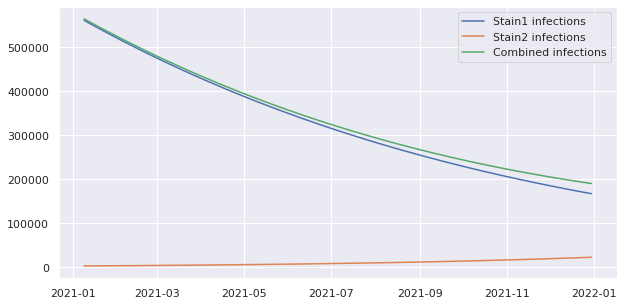

In [63]:
plt.figure(figsize=(10,5))
plt.plot(dates, Is1, label='Stain1 infections')
plt.plot(dates, Is2, label='Stain2 infections')
plt.plot(dates, Is1 + Is2, label='Combined infections')
#plt.yticks([0, 2e6, 4e6, 6e6, 8e6])
plt.legend()
plt.show()